<div style="background-color:#009440; padding: 0px; background-size:cover; background-opacity:50%; border-radius:5px; height:300px">
    <div style="margin: 5px; padding: 10px;">
    <h1 style="color:#00000">Geophysical Data Acquisition and Analysis</h1>
    <h5 style="color:#C0C0C0">LMU, July 31, 2020</h5>
    <h4 style="color:rgba(0,0,0,0.6)">Alice Gabriel, Tobias Megies, Stephanie Wollherr, Joachim Wassermann</h4>
    </div>
    <div style="float:right; margin: 20px; padding: 20px; background:rgba(255,255,255,0.7); width: 70%; height: 100px">
        <div style="position:relative; top:40%; transform: translateY(-50%)">
        <div style="font-size: x-large; font-weight:900; color:rgba(0,0,0,0.8); line-height:100%">P11 - Seismometer response & equation</div>
        </div>
    </div>
   
</div>

**Please, do not forget to execute Cell 1 first!**

In [1]:
# Cell 1: Preparation for programming
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')                  # do not show warnings
from scipy import interpolate, signal
from time import *
import numpy as np
from obspy import *
from obspy.core import read, UTCDateTime
from obspy.clients.fdsn import Client
from obspy.signal.invsim import paz_to_freq_resp
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import os
import glob
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['figure.facecolor'] = 'w'  # remove grey background

## Exercise 1: Effect of damping on seismometer response

In this exercise we will get acquainted with the seismometer response function. In the code cell below, you will find the poles and zeros of a mechanical seismometer.


a) Estimate the eigenfrequency and the dampig of the system (out of the given impulse response). Plot the amplitude and phase transfer function

b) Change the poles amd zeros to match the following eigenfrequencies and damping pairs 1.0:0.2; 1.0:0.5; 1.0:0.7; 2.0:0.6. Descripe what you see

c) What would change if the sensor is changed to be a electro-dynamic sensor but the impulse still represents a pulse in displacement?


<IPython.core.display.Javascript object>


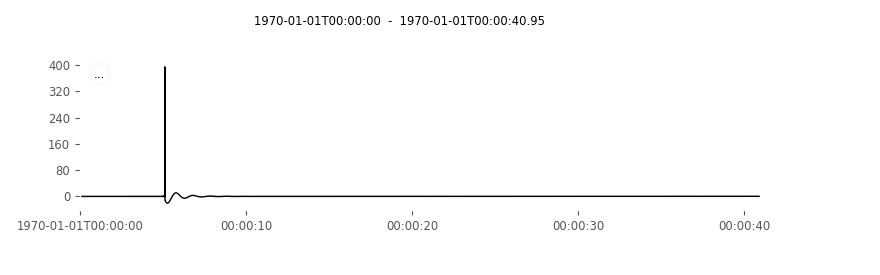

<IPython.core.display.Javascript object>


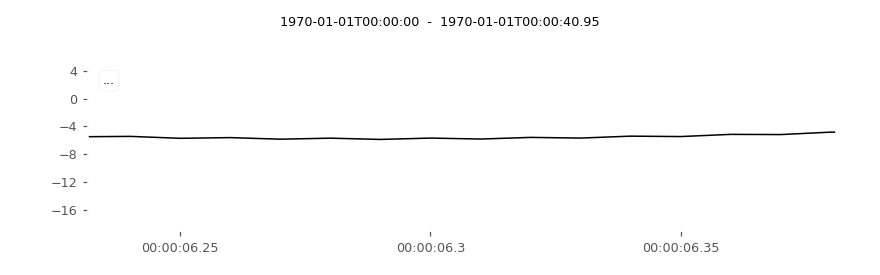

In [2]:
from obspy import *
import numpy as np
paz1 = {'poles': [-1.2566-6.15763j,-1.2566+6.15763j],
            'zeros': [0j, 0j],
            'gain': 1.0,
            'sensitivity': 400.0}
tr = Trace()
tr.stats.sampling_rate=100
tr.data = np.zeros(4096)
tr.data[511] = 1.
tr.simulate(paz_simulate=paz1)
tr.plot()

## Answer
1a) 
Zooming into the first and second Minimum and reading the timing of the corresponding minimum values gives 5.27 and 6.31 s, respectivly. The period of the damped system is thus 1.04 s. The corresponding amplitudes are -20.7 and -5.8, respectively. Using the formula for the logarithmic decrement gives a value of 1.27 and with that an damping factor of h=0.324. The free period of the seismometer is than 0.98s. The true values out of the poles and zeros given in the code and using the quadratic formula are 1.0 s and 0.2 and gives us a hint how "precise" this method is.

1b)
Using extensively the quadratic formular gives following poles and zeros distirbution:
1.0,0.2: -1.2566 -+ 6.15763j 
1.0,0.5: -3.1416 -+ 5.4414j
1.0,0.7: -4.3982 -+ 4.4871j
2.0,0.6: -7.5398 -+ 10.0531j

1c)
as we need to integrate the velocity propotional output (or differentiate the output) to be in the same physical dimensions we have to devide the denominator of the transfer function equation. Applying this in the Lapalce domain will simply result in a third zero:

$T(s)=\frac{s^{2}}{s^{2}+2sh\omega_{0}+\omega_{0}^{2}}$ (transfer function mechanical system)
is getting to:

$T(s)=\frac{s^{3}}{s^{2}+2sh\omega_{0}+\omega_{0}^{2}}$ (transfer function of electro dynamic system with an displacement impulse as input)

## Exercise 2: Seismometer characteristics

Recall the seismometer equation:

$\ddot{x}_r (t)+ 2\epsilon \dot{x}_r (t) + \omega_0^2 x_r (t) = -\ddot{u}_g$

where $2 \epsilon = \frac{D}{m} = 2h\omega_0$ is the damping factor, $\omega_0$ the natural frequency of the seismometer, $x_r$ the relative displacement of the mass within the seismometer, and $\ddot{u}_g$ the ground accelleration. 


a) What happens to $\ddot{x}_r$ (acceleration of the mass) when the mass moves very rapidly? What does that mean for $\dot{x}_r$ and $x_r$? What does the seismometer measure in that case?

b) Similarly, when the mass moves slowly: what happens to $\ddot{x}_r$ and $\dot{x}_r$? What do you measure? 

c) Can you interpret the two different shapes you saw in 1b) and 1c)? Hint: the output of the cell 3 may help!

## Answers and hints

a) and b)

For slow movements the acceleration and velocity becomes negligible, thus the seismometer records ground acceleration.

For fast movements the acceleration of the mass dominates and the seismometer records ground displacement.

You can see this by analysing what happens at peaks in velocity (e.g. accelerations are 0) and zero crossings 
of velocity = 0 (maxima in acceleration)

Or in other words: with the ground moving very slowly, the mass would have time to follow the ground motion, thus the gain would be low.


c) Note that a Wood-Anderson instrument is a short-period instrument. Here you can explain why a seismometer without force feedback mechanisms cannot record reliably at frequencies lower than its natural frequency.

### Auxiliary plot: derivatives of source function

<IPython.core.display.Javascript object>


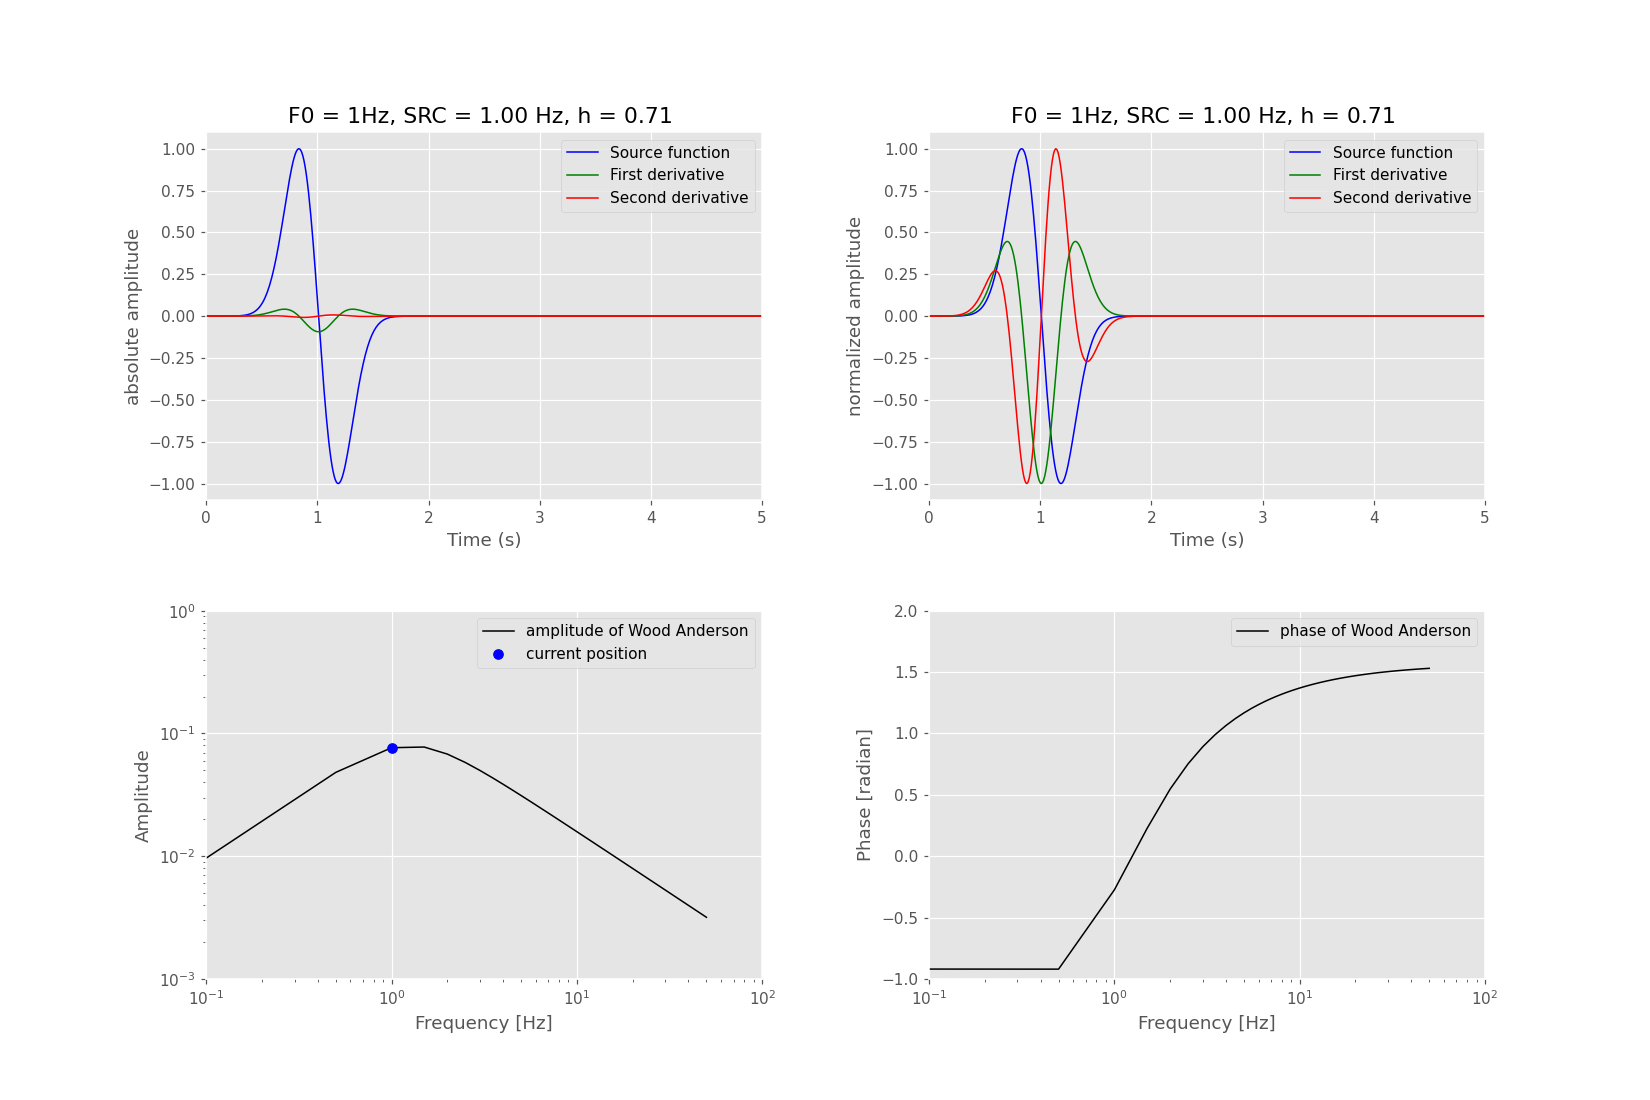

In [3]:
# Cell 3
dt = .01                                                 # time increment for numerical scheme

fu0=1  #you can adjust these parameters
h=0.707  #you can adjust these parameters
f_forcing=1.0 #you can adjust these parameters

# initialize ground motion
p = 1. / f_forcing
nts = int(2. * p / dt)
uii = np.zeros(nts)
t0 = p / dt
a_ricker = 4. / p
for it in range(nts):
    t = (it - t0) * dt
    uii[it] = -2 * a_ricker * t * np.exp(-(a_ricker * t) ** 2)
# end initialize ground motion

nt = int(round(5. * 1. / fu0 / dt))                     # total number of time steps
src = np.zeros(nt)
src[0:len(uii)] = uii

time = np.dot(np.arange(1, nt+1), dt)
source = src[0:nt] / np.max(src[0:nt])
firstderiv =np.gradient(source)
secondderiv = np.gradient(firstderiv)

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(time, source, 'b', label='Source function')
plt.plot(time, firstderiv, 'g', label='First derivative' )
plt.plot(time, secondderiv, 'r', label='Second derivative')
plt.title("F0 = 1Hz, SRC = %.2f Hz, h = %.2f " % (fu0, h))
plt.axis([0, nt*dt, -1, 1])
plt.ylabel("absolute amplitude")
plt.ylim(-1.1,1.1)
plt.xlabel("Time (s)")
plt.legend()

plt.subplot(222)
plt.plot(time, source, 'b', label='Source function')
plt.plot(time, firstderiv/np.max(np.abs((firstderiv))), 'g', label='First derivative' )
plt.plot(time, secondderiv/np.max(np.abs((secondderiv))), 'r', label='Second derivative')
plt.title("F0 = 1Hz, SRC = %.2f Hz, h = %.2f " % (fu0, h))
plt.axis([0, nt*dt, -1, 1])
plt.ylabel("normalized amplitude")
plt.ylim(-1.1,1.1)
plt.xlabel("Time (s)")
plt.legend()

# preparation for subplot 3+4
poles = [-6.2832-4.7124j, -6.2832+4.7124j]
zeros = [0j]
gain = 1.0
h2, f = paz_to_freq_resp(poles, zeros, gain, dt, 200, freq=True)
ind = (f==fu0).nonzero()[0]
amp = abs(h2[ind])
# end preparation subplot 3+4

plt.subplot(223)
plt.loglog(f, abs(h2), 'k', label="amplitude of Wood Anderson")
plt.plot(fu0, amp,'bo', label="current position")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.ylim(0.001, 1.)
plt.xlim(0.1,100)
plt.legend()

plt.subplot(224)
# take negative of imaginary part, see documentation of paz_to_freq_resp 
phase = np.unwrap(np.arctan2(-h2.imag, h2.real))
plt.semilogx(f, phase, 'k', label="phase of Wood Anderson")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [radian]')
plt.xlim(0.1,100)
plt.ylim(-1,2)
plt.legend()

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()